<a href="https://colab.research.google.com/github/naenumtou/ifrs9/blob/main/PD/externalMatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

%config InlineBackend.figure_format = 'retina'
pd.options.display.float_format = '{:.4f}'.format #Change display format in DataFrame table

In [2]:
# Import dataset
# External rating from Moody's
externalMatrix = pd.read_csv('https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/transitionMoody.csv')
externalMatrix

,Rating,Aaa,Aa1,Aa2,Aa3,A1,A2,A3,Baa1,Baa2,Baa3,Ba1,Ba2,Ba3,B1,B2,B3,Caa1,Caa2,Caa3,Ca,C,Default
0,Aaa,0.9380,0.0415,0.0155,0.0024,0.0011,0.0002,0.0000,0.0007,0.0000,0.0002,0.0002,0.0002,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,Aa1,0.0241,0.8132,0.0920,0.0512,0.0160,0.0005,0.0011,0.0003,0.0008,0.0001,0.0002,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0003,0.0000,0.0000,0.0000,0.0000
2,Aa2,0.0079,0.0408,0.7935,0.1040,0.0362,0.0143,0.0013,0.0009,0.0004,0.0000,0.0002,0.0001,0.0000,0.0002,0.0000,0.0000,0.0000,0.0001,0.0000,0.0001,0.0000,0.0000
3,Aa3,0.0009,0.0089,0.0455,0.7952,0.0960,0.0382,0.0070,0.0030,0.0027,0.0012,0.0002,0.0000,0.0002,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0009
4,A1,0.0001,0.0009,0.0109,0.0621,0.7905,0.0837,0.0310,0.0095,0.0039,0.0022,0.0021,0.0016,0.0003,0.0005,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0004
5,A2,0.0011,0.0010,0.0028,0.0111,0.0727,0.7800,0.0738,0.0322,0.0118,0.0051,0.0033,0.0023,0.0015,0.0004,0.0003,0.0001,0.0000,0.0001,0.0001,0.0000,0.0000,0.0003
6,A3,0.0013,0.0007,0.0010,0.0044,0.0225,0.0800,0.7791,0.0628,0.0253,0.0113,0.0047,0.0015,0.0013,0.0023,0.0006,0.0004,0.0000,0.0001,0.0001,0.0000,0.0000,0.0005
7,Baa1,0.0001,0.0002,0.0013,0.0015,0.0055,0.0321,0.0849,0.7582,0.0679,0.0279,0.0078,0.0037,0.0023,0.0034,0.0002,0.0007,0.0001,0.0004,0.0000,0.0004,0.0000,0.0012
8,Baa2,0.0001,0.0002,0.0010,0.0010,0.0028,0.0105,0.0414,0.0910,0.7534,0.0630,0.0147,0.0045,0.0053,0.0051,0.0023,0.0001,0.0001,0.0016,0.0004,0.0001,0.0000,0.0014
9,Baa3,0.0000,0.0002,0.0002,0.0008,0.0019,0.0043,0.0072,0.0332,0.0987,0.7470,0.0560,0.0182,0.0127,0.0064,0.0032,0.0062,0.0004,0.0009,0.0001,0.0002,0.0000,0.0022


In [3]:
# Define plot function
def plotDefault(data, name, rating, dotvar, linevar, line = False):
  plt.figure(figsize = (12, 7))
  with plt.style.context('seaborn'):
    ax = sns.scatterplot(x = data.index, y = dotvar, data = data)
    if line is True:
      ax = sns.lineplot(x = data.index, y = linevar, data = data, color = 'orange')
    ax.set_title(name)
    ax.set_xticks(data.index)
    ax.set_xticklabels(list(data[rating]))
    ax.set(xlabel = 'Rating', ylabel = 'Default rate')      
  return plt.show()

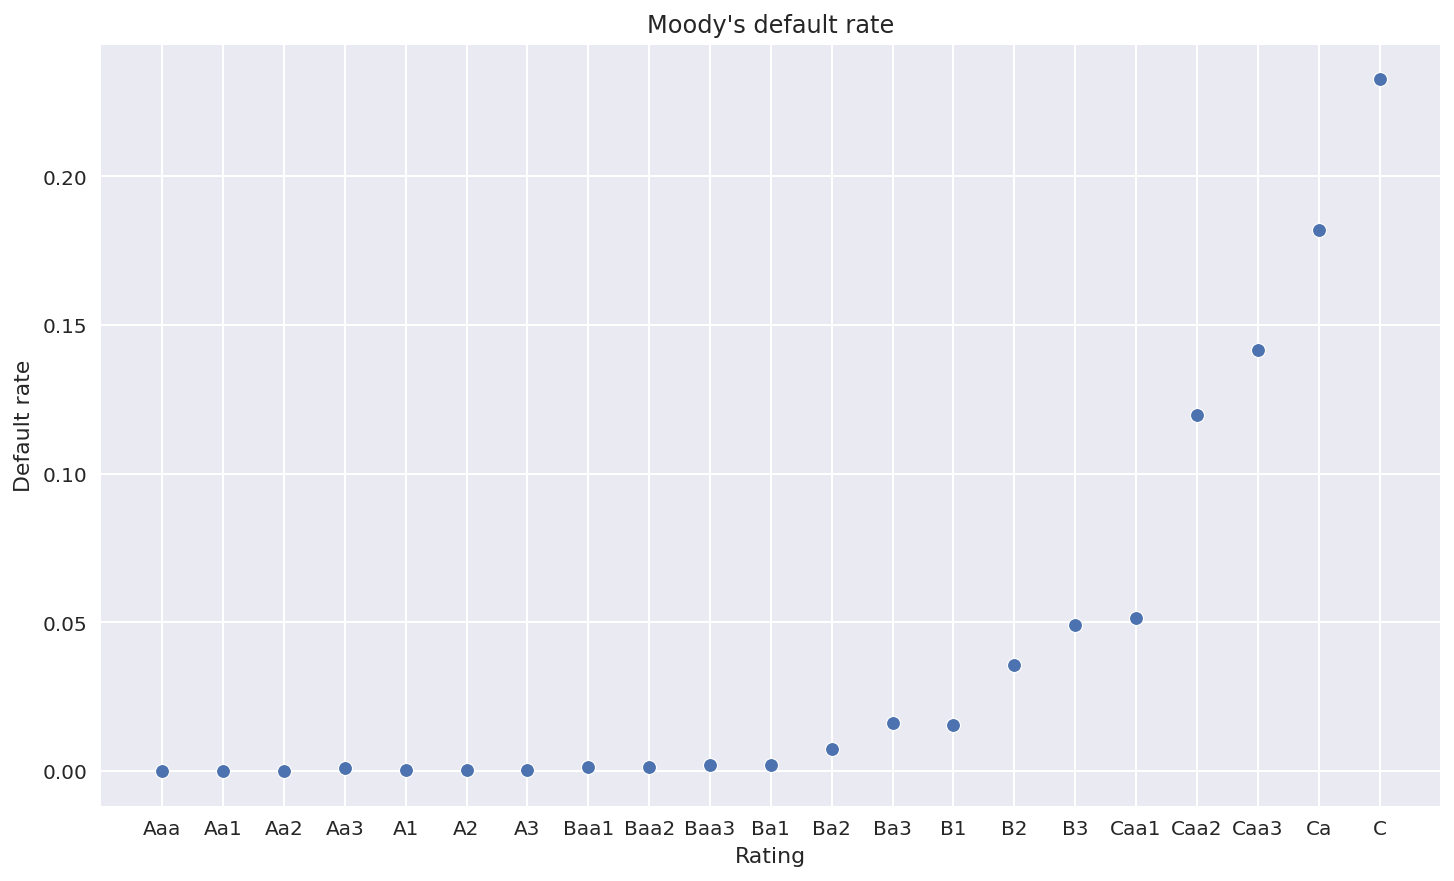

In [4]:
# Plot
externalDefault = externalMatrix[['Rating', 'Default']]
externalDefault = externalDefault.query("Rating != 'Default'")
plotDefault(externalDefault, "Moody's default rate", 'Rating', 'Default', None)

In [5]:
# Create transition matrix table
index = pd.MultiIndex.from_product([["Moody's"], externalMatrix['Rating']],
                                   names = ['Source', 'Rating']) #Multi-index names
externalMatrix.index = index #Assign index
externalMatrix = externalMatrix.drop(['Rating'], axis = 1)
externalMatrix

Aaa    Aa1    Aa2    Aa3  ...   Caa3     Ca      C  Default
Source  Rating                               ...                              
Moody's Aaa     0.9380 0.0415 0.0155 0.0024  ... 0.0000 0.0000 0.0000   0.0000
        Aa1     0.0241 0.8132 0.0920 0.0512  ... 0.0000 0.0000 0.0000   0.0000
        Aa2     0.0079 0.0408 0.7935 0.1040  ... 0.0000 0.0001 0.0000   0.0000
        Aa3     0.0009 0.0089 0.0455 0.7952  ... 0.0000 0.0000 0.0000   0.0009
        A1      0.0001 0.0009 0.0109 0.0621  ... 0.0000 0.0000 0.0000   0.0004
        A2      0.0011 0.0010 0.0028 0.0111  ... 0.0001 0.0000 0.0000   0.0003
        A3      0.0013 0.0007 0.0010 0.0044  ... 0.0001 0.0000 0.0000   0.0005
        Baa1    0.0001 0.0002 0.0013 0.0015  ... 0.0000 0.0004 0.0000   0.0012
        Baa2    0.0001 0.0002 0.0010 0.0010  ... 0.0004 0.0001 0.0000   0.0014
        Baa3    0.0000 0.0002 0.0002 0.0008  ... 0.0001 0.0002 0.0000   0.0022
        Ba1     0.0000 0.0000 0.0002 0.0000  ... 0.0014 0.0010 0.0002   0.0021
        Ba2     0.0000 0.0000 0.0000 0.0000  ... 0.0026 0.0000 0.0004   0.0075
        Ba3     0.0000 0.0000 0.0000 0.0000  ... 0.0004 0.0063 0.0002   0.0163
        B1      0.0000 0.0000 0.0000 0.0000  ... 0.0004 0.0082 0.0006   0.0155
        B2      0.0000 0.0004 0.0000 0.0005  ... 0.0020 0.0075 0.0000   0.0356
        B3      0.0000 0.0000 0.0000 0.0000  ... 0.0029 0.0124 0.0007   0.0489
        Caa1    0.0000 0.0000 0.0000 0.0000  ... 0.0349 0.0016 0.0025   0.0516
        Caa2    0.0000 0.0000 0.0000 0.0000  ... 0.0530 0.0114 0.0326   0.1196
        Caa3    0.0000 0.0000 0.0000 0.0000  ... 0.5253 0.0483 0.0356   0.1415
        Ca      0.0000 0.0000 0.0000 0.0000  ... 0.0890 0.5753 0.0210   0.1818
        C       0.0000 0.0000 0.0000 0.0000  ... 0.0104 0.0347 0.6493   0.2326
        Default 0.0000 0.0000 0.0000 0.0000  ... 0.0000 0.0000 0.0000   1.0000

[22 rows x 22 columns]

In [6]:
# External default rate adjustment
# Data adjustment
externalKeep = externalDefault.query("Default == 0")
externalDefault = externalDefault.query("Default != 0") #Drop 0% PD

# Data for fitting
x = np.array(externalDefault.index).reshape(-1, 1)
y = np.array(externalDefault['Default']).reshape(-1, 1)

In [7]:
# Fitting linear model with logit function
model = LinearRegression()
model.fit(x, np.log(y))

# Score
print(f'R-Square: {model.score(x, np.log(y)): .4f}')

R-Square:  0.9539


In [30]:
# Fitted result
externalDefault['fittedDefault'] = np.exp(model.predict(x)).reshape(1, -1)[0] #Fitted results
fittedResult = pd.concat([externalKeep, externalDefault], axis = 0) #Concat 0% PD Back
fittedResult['fittedDefault'] = fittedResult['fittedDefault'].fillna(0)
fittedResult

,Rating,Default,fittedDefault
0,Aaa,0.0000,0.0000
1,Aa1,0.0000,0.0000
2,Aa2,0.0000,0.0000
3,Aa3,0.0009,0.0002
4,A1,0.0004,0.0004
5,A2,0.0003,0.0006
6,A3,0.0005,0.0009
7,Baa1,0.0012,0.0013
8,Baa2,0.0014,0.0020
9,Baa3,0.0022,0.0030


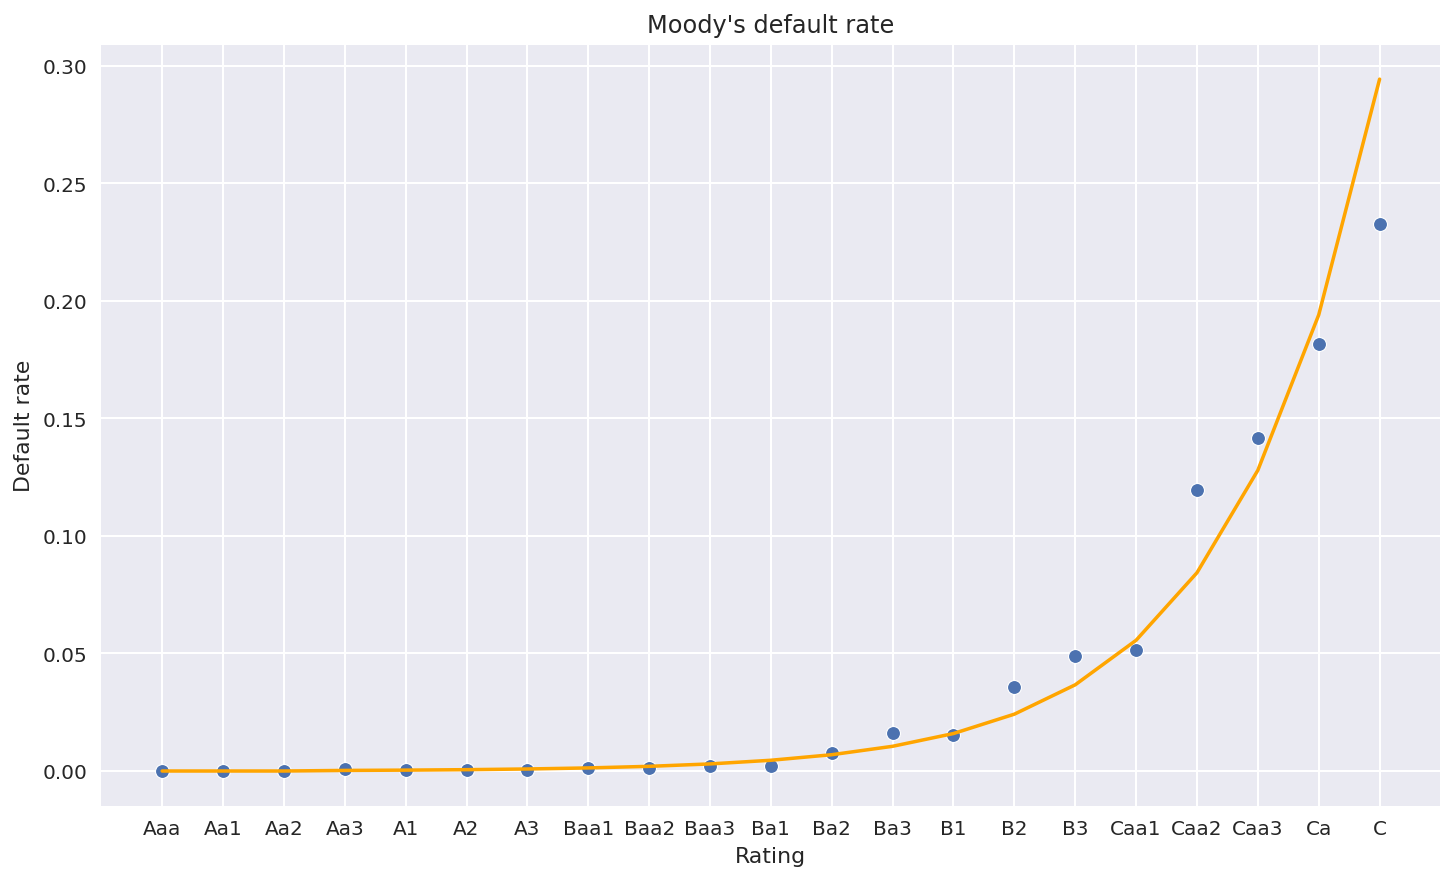

In [9]:
# Plot
plotDefault(fittedResult, "Moody's default rate", 'Rating', 'Default', 'fittedDefault', line = True)

In [ ]:
'''
# Example for curve fitting approach
from scipy.optimize import curve_fit

# Define exponential function
def fittingPD(x, a, b, c):
  return a * (b**x) + c

# Initial guesses
initialGuesses = [1, 1, 1]

# Fitting
popt, pcov = curve_fit(fittingPD, x, y, initialGuesses)

# Result
fittingPD(x, *popt)
'''

### Table mapping external rating to internal rating
Moody's rating | Internal rating
---------------|------------------
Aaa | A1
Aa1 | A1
Aa2 | A1
Aa3 | A1
A1 | A2
A2 | A2
A3 | A2
Baa1 | A2
Baa2 | B1
Baa3 | B2
Ba1 | B3
Ba2 | 
Ba3 | 
B1 | B5
B2 | C1
B3 | C2
Caa1 | C2
Caa2 | C3
Caa3 | C3
Ca | C4
C | C5

In [11]:
# Mapping to internal rating model
# Create dictionay for mapping
ratingMapping = {
    'Aaa': 'A1',
    'Aa1': 'A1',
    'Aa2': 'A1',
    'Aa3': 'A1',
    'A1': 'A2',
    'A2': 'A2',
    'A3': 'A2',
    'Baa1': 'A2',
    'Baa2': 'B1',
    'Baa3': 'B2',
    'Ba1': 'B3',
    'Ba2': np.nan,
    'Ba3': np.nan,
    'B1': 'B5',
    'B2': 'C1',
    'B3': 'C2',
    'Caa1': 'C2',
    'Caa2': 'C3',
    'Caa3': 'C3',
    'Ca': 'C4',
    'C': 'C5',
}

# Copy fitted result
mappedResult = pd.DataFrame.copy(fittedResult)
mappedResult['internalRating'] = mappedResult['Rating'].map(ratingMapping)
mappedResult.head(5)

,Rating,Default,fittedDefault,internalRating
0,Aaa,0.0000,0.0000,A1
1,Aa1,0.0000,0.0000,A1
2,Aa2,0.0000,0.0000,A1
3,Aa3,0.0009,0.0002,A1
4,A1,0.0004,0.0004,A2


In [12]:
# Linear interpolation for unmatched rating
mappedResult['fittedDefault'] = np.where(mappedResult['internalRating'].isnull(), np.nan, mappedResult['fittedDefault'])

# Remove one of unmatched for linear interpolation (not average)
mappedResult = mappedResult[mappedResult.index != mappedResult['fittedDefault'].isnull().idxmax()] #First invalid index

# Interpolation
mappedResult['fittedDefault'] = mappedResult['fittedDefault'].interpolate(method = 'linear', axis = 0)

# Assign unmatched rating
mappedResult['internalRating'] = mappedResult['internalRating'].fillna('B4')

In [13]:
# Simple average to internal rating
mappedResult = mappedResult.groupby(['internalRating'], as_index = False)['fittedDefault'].mean()
mappedResult.head(5)

,internalRating,fittedDefault
0,A1,0.0001
1,A2,0.0008
2,B1,0.0020
3,B2,0.0030
4,B3,0.0046


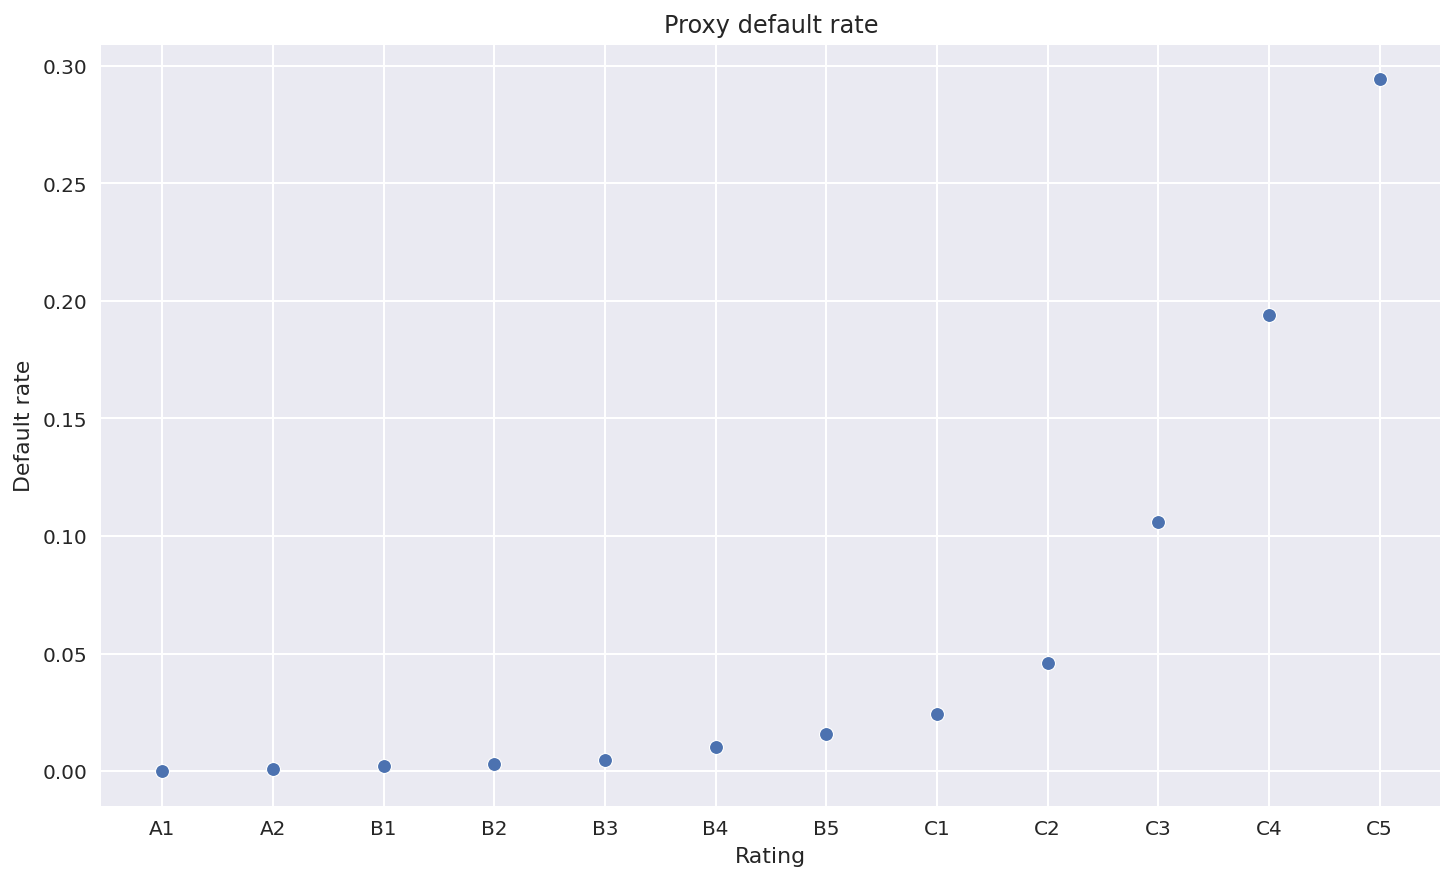

In [14]:
# Plot
plotDefault(mappedResult, "Proxy default rate", 'internalRating', 'fittedDefault', None, line = False)

In [15]:
# Import dataset
# ODR by internal rating
lowDefault = pd.read_csv('https://raw.githubusercontent.com/naenumtou/ifrs9/main/PD/datasets/lowDefaultRating.csv')
lowDefault = lowDefault.eval("ODR = Bad / N")
lowDefault

,internalRating,N,Bad,ODR
0,A1,12,1,0.0833
1,A2,15,0,0.0000
2,B1,18,2,0.1111
3,B2,12,1,0.0833
4,B3,7,1,0.1429
5,B4,5,0,0.0000
6,B5,16,1,0.0625
7,C1,14,0,0.0000
8,C2,19,1,0.0526
9,C3,16,3,0.1875


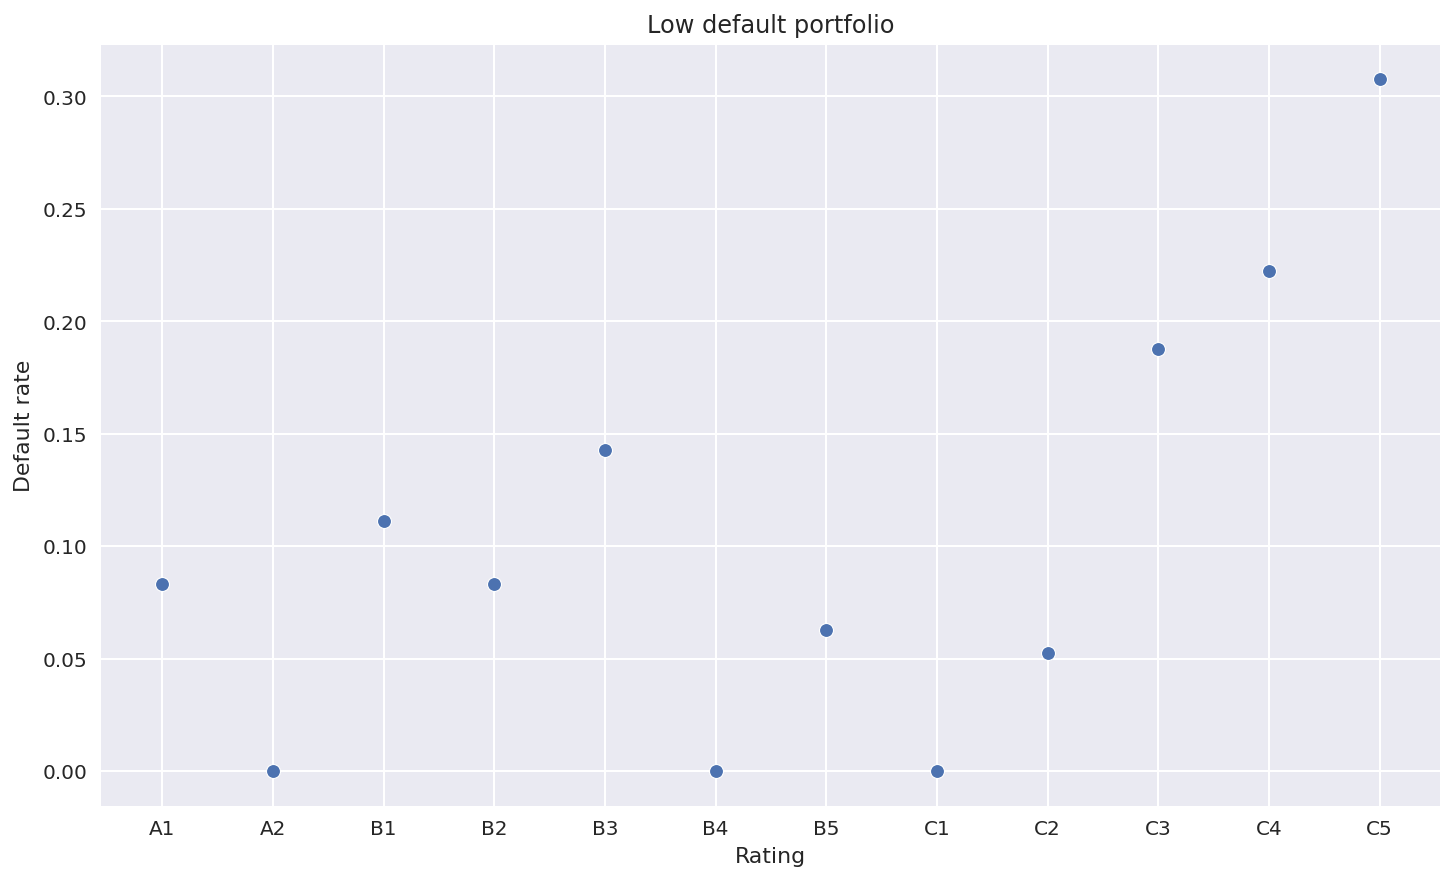

In [16]:
# Plot
plotDefault(lowDefault, "Low default portfolio", 'internalRating', 'ODR', None)

In [17]:
# Calibration to ODR by internal rating
# Define PD Caliobration function
def fittingPD(x):

  # Define data array
  proxyPD = np.array(mappedResult['fittedDefault'])
  odr = np.array(lowDefault['ODR'])
  n = np.array(lowDefault['N'])

  # Apply scaling factor to ODR
  scaledPD = odr * x

  # Weighted average
  scaledPDAvg = np.average(scaledPD, weights = n)
  proxyPDAvg = np.average(proxyPD, weights = n)

  # Error
  error = np.abs(scaledPDAvg - proxyPDAvg)
  return error

# Define minimise error function
def findScalar(x):
  return fittingPD(x)

In [18]:
# Initial guess
init = [1]

# Finding scalar
scalarOpt = minimize(findScalar, init)

In [19]:
# Scalar result
scalar = scalarOpt.x[0]
print(f'Scaling factor: {scalar:.4f}')

Scaling factor: 0.5568


In [20]:
# Apply scalar to external fiited default rate
fittedResult['scaledDefault'] = fittedResult['fittedDefault'] * scalar
fittedResult

,Rating,Default,fittedDefault,scaledDefault
0,Aaa,0.0000,0.0000,0.0000
1,Aa1,0.0000,0.0000,0.0000
2,Aa2,0.0000,0.0000,0.0000
3,Aa3,0.0009,0.0002,0.0001
4,A1,0.0004,0.0004,0.0002
5,A2,0.0003,0.0006,0.0003
6,A3,0.0005,0.0009,0.0005
7,Baa1,0.0012,0.0013,0.0007
8,Baa2,0.0014,0.0020,0.0011
9,Baa3,0.0022,0.0030,0.0017


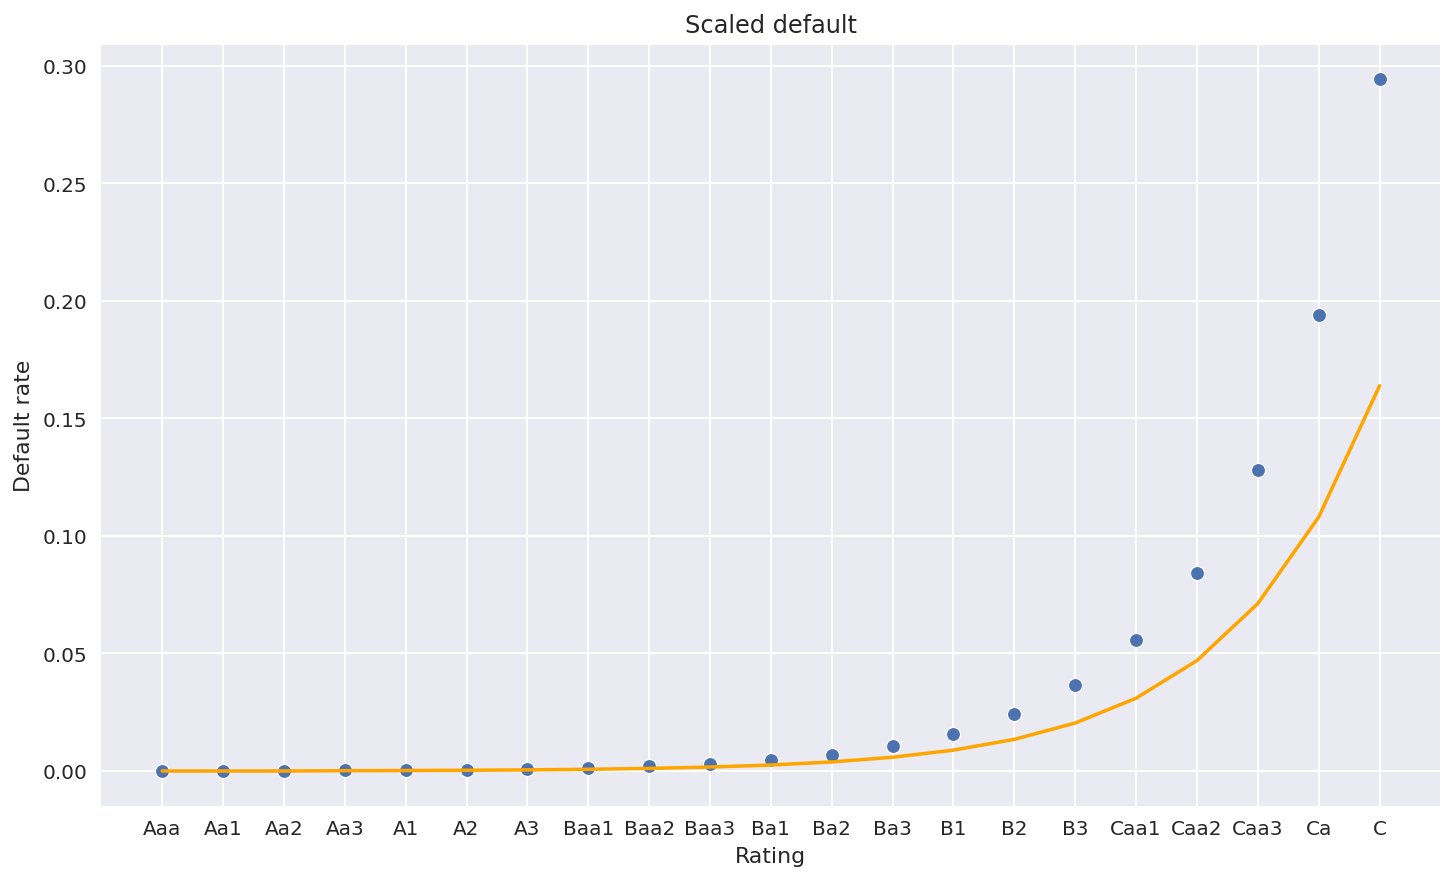

In [21]:
# Plot
plotDefault(fittedResult, "Scaled default", 'Rating', 'fittedDefault', 'scaledDefault', line = True)

In [22]:
# Apply to external transition matrix
# adjPD = PD * ((1 - scaledDefault) / (1 - oldDefault))
# Sum of row must be 100%
adjDefault = (1 - fittedResult['scaledDefault']).values /  (1 - externalMatrix[:-1]['Default']).values

# Adjusted matrix
matrixAdj = externalMatrix[:-1].mul(adjDefault, axis = 0) #Multiply without default row
matrixAdj['Default'] = list(fittedResult['scaledDefault']) #Assign scaled default rate
matrixAdj = pd.concat([matrixAdj, externalMatrix[-1:]],
                      axis = 0) #Add default row
# Assign index names
index = pd.MultiIndex.from_product([["Adjustment"], externalMatrix.index.get_level_values(1)],
                                   names = ['Source', 'Rating']) #Multi-index names
matrixAdj.index = index #Assign index
matrixAdj

Aaa    Aa1    Aa2    Aa3  ...   Caa3     Ca      C  Default
Source     Rating                               ...                              
Adjustment Aaa     0.9380 0.0415 0.0155 0.0024  ... 0.0000 0.0000 0.0000   0.0000
           Aa1     0.0241 0.8132 0.0920 0.0512  ... 0.0000 0.0000 0.0000   0.0000
           Aa2     0.0079 0.0408 0.7935 0.1040  ... 0.0000 0.0001 0.0000   0.0000
           Aa3     0.0009 0.0089 0.0455 0.7958  ... 0.0000 0.0000 0.0000   0.0001
           A1      0.0001 0.0009 0.0109 0.0621  ... 0.0000 0.0000 0.0000   0.0002
           A2      0.0011 0.0010 0.0028 0.0111  ... 0.0001 0.0000 0.0000   0.0003
           A3      0.0013 0.0007 0.0010 0.0044  ... 0.0001 0.0000 0.0000   0.0005
           Baa1    0.0001 0.0002 0.0013 0.0015  ... 0.0000 0.0004 0.0000   0.0007
           Baa2    0.0001 0.0002 0.0010 0.0010  ... 0.0004 0.0001 0.0000   0.0011
           Baa3    0.0000 0.0002 0.0002 0.0008  ... 0.0001 0.0002 0.0000   0.0017
           Ba1     0.0000 0.0000 0.0002 0.0000  ... 0.0014 0.0010 0.0002   0.0025
           Ba2     0.0000 0.0000 0.0000 0.0000  ... 0.0026 0.0000 0.0004   0.0039
           Ba3     0.0000 0.0000 0.0000 0.0000  ... 0.0005 0.0064 0.0002   0.0059
           B1      0.0000 0.0000 0.0000 0.0000  ... 0.0004 0.0082 0.0006   0.0089
           B2      0.0000 0.0005 0.0000 0.0005  ... 0.0020 0.0077 0.0000   0.0135
           B3      0.0000 0.0000 0.0000 0.0000  ... 0.0030 0.0128 0.0008   0.0204
           Caa1    0.0000 0.0000 0.0000 0.0000  ... 0.0356 0.0017 0.0025   0.0310
           Caa2    0.0000 0.0000 0.0000 0.0000  ... 0.0574 0.0123 0.0353   0.0470
           Caa3    0.0000 0.0000 0.0000 0.0000  ... 0.5683 0.0523 0.0385   0.0712
           Ca      0.0000 0.0000 0.0000 0.0000  ... 0.0970 0.6272 0.0229   0.1081
           C       0.0000 0.0000 0.0000 0.0000  ... 0.0114 0.0378 0.7075   0.1639
           Default 0.0000 0.0000 0.0000 0.0000  ... 0.0000 0.0000 0.0000   1.0000

[22 rows x 22 columns]

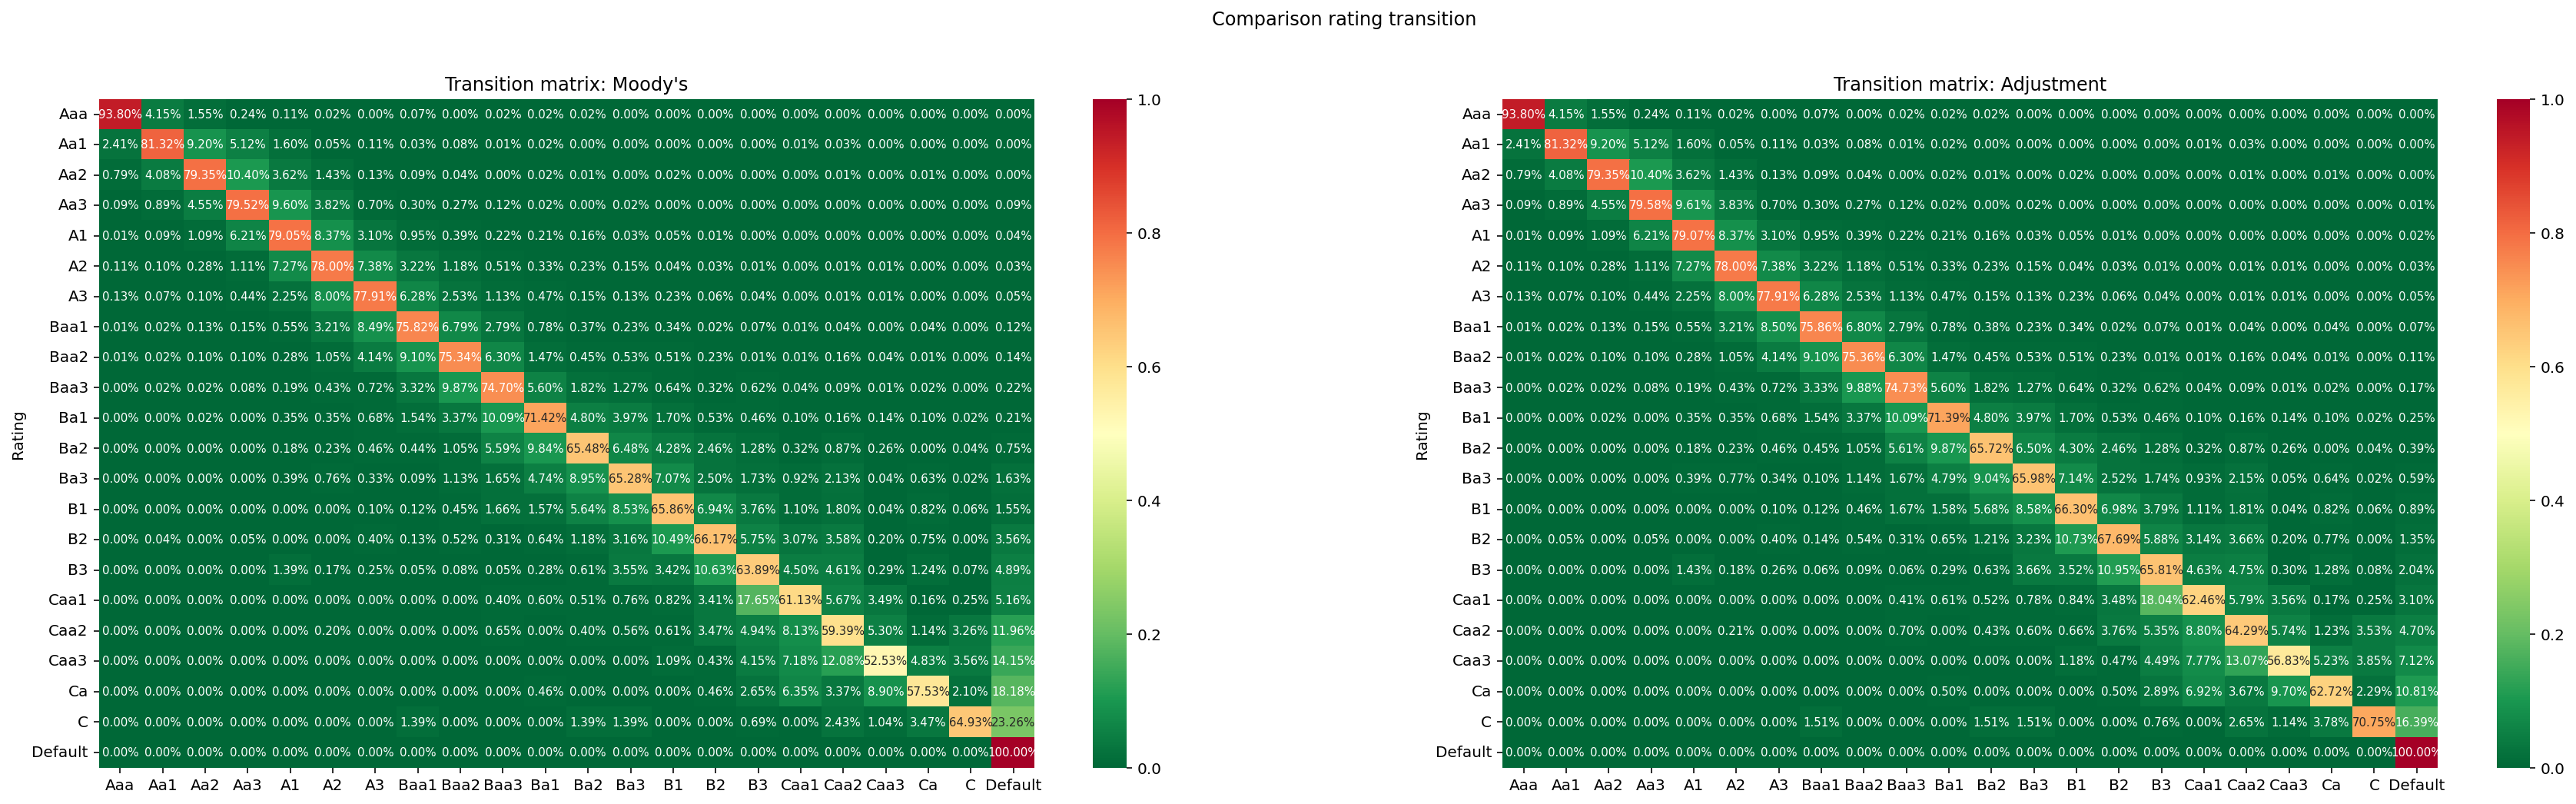

In [23]:
# Combine table
externalResult = pd.concat([externalMatrix, matrixAdj], axis = 0)

# Plot result
fig, axs = plt.subplots(1, 2, figsize = (30, 8))
for i, source in enumerate(externalResult.index.get_level_values(0).unique()):
  fig.suptitle('Comparison rating transition')
  selectData = externalResult.loc[source]
  sns.heatmap(selectData, annot = True,
              annot_kws = {'fontsize': 7.5},
              fmt = '.2%', cmap = 'RdYlGn_r',
              ax = axs[i])
  axs[i].set_title(f'Transition matrix: {source}')
plt.show()

In [24]:
# Matrix multiplication for lifetime
years = 30 #Create lifetime PD for 30-years
lifetimeResults = None

lifetime = matrixAdj.to_numpy() #Select segment and convert to array
baseMatrix = lifetime.copy()
lifetimePD = lifetime[:, -1][:-1] #Keep first year PD but not 'Default' row
for i in range(years):
  if i == 0:
    pass
  else:
    lifetimeCum = np.dot(baseMatrix, lifetime[-baseMatrix.shape[0]:, :]) #Base * latest cumulative matrix
    lifetime = np.vstack((lifetime, lifetimeCum)) #Keep cumulative matrix
    lifetimePD = np.vstack((lifetimePD, lifetimeCum[:, -1][:-1])) #Keep only default bucket but not 'Default' row
    lifetimeResult = pd.DataFrame(lifetimePD, columns = range(lifetimePD.shape[1])) #Format to DataFrame
if lifetimeResults is None:
  lifetimeResults = lifetimeResult.copy()
else:
  lifetimeResults = pd.concat([lifetimeResults, lifetimeResult], axis = 0, ignore_index = False) #Keep index

# Create times
lifetimeResults.columns = matrixAdj.index.get_level_values(1)[:-1]

In [25]:
# Define function to long table
def longTable(data, varName, valueName):
  plotData = pd.DataFrame.copy(data)
  plotData['times'] = plotData.index + 1
  return pd.melt(plotData, id_vars = 'times', var_name = varName, value_name = valueName)

# Define plot function
def plotLifetime(data, name, rating, linevar):
  plt.figure(figsize = (12, 7))
  with plt.style.context('seaborn'):
    ax = sns.lineplot(x = 'times', y = linevar, data = data,
                      hue = rating, legend = 'full',
                      palette = 'viridis', ci = None)
    ax.set_title(name)
    ax.set(xlabel = 'Years', ylabel = 'Cumulative PD')  
  return plt.show()

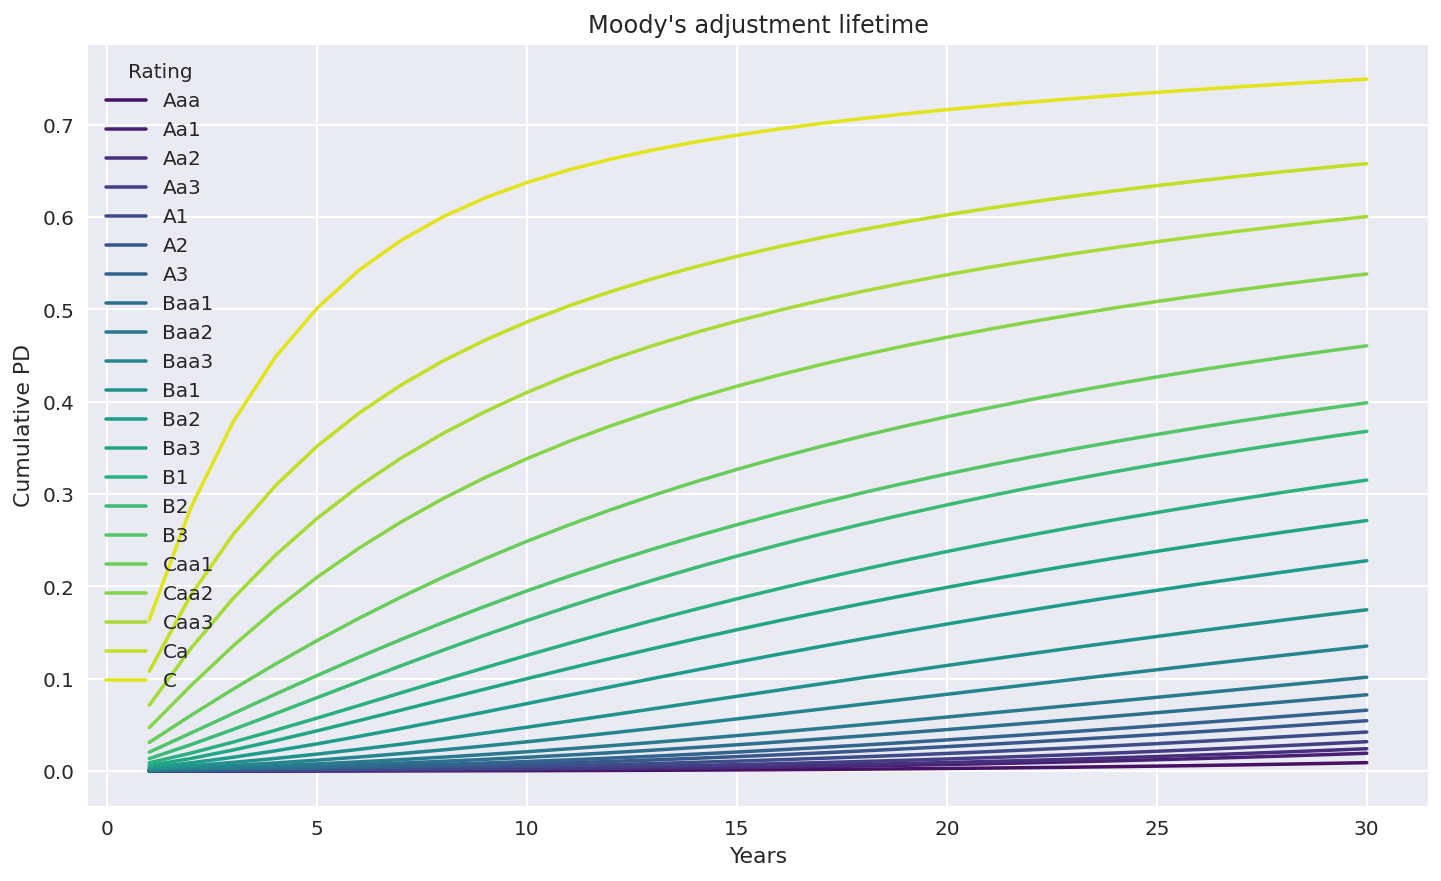

In [26]:
# Plot
plotLifetime(longTable(lifetimeResults, 'Rating', 'cumPD'),
             "Moody's adjustment lifetime", 'Rating', 'cumPD')

In [27]:
# Internal rating lifetime
# Mappinn internal rating
lifetimeInternal = lifetimeResults.T #Transpose matrix
lifetimeInternal['internalRating'] = lifetimeInternal.index.map(ratingMapping)

# Remove one of unmatched for linear interpolation (not average)
lifetimeInternal = lifetimeInternal[lifetimeInternal.index != lifetimeInternal['internalRating'].isnull().idxmax()] #First invalid index

# Remove lifetime before interpolation
lifetimeInternal.loc[lifetimeInternal['internalRating'].isnull().idxmax()] = np.nan

# Interpolation
lifetimeInternal = lifetimeInternal.interpolate(method = 'linear', axis = 0) #Apply for all lifetime

# Assign unmatched rating
lifetimeInternal['internalRating'] = lifetimeInternal['internalRating'].fillna('B4')

# Summary table
lifetimeInternal = lifetimeInternal.groupby(['internalRating'], as_index = False).mean()
lifetimeInternal

,internalRating,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,A1,0.0000,0.0001,0.0002,0.0003,0.0004,0.0006,0.0008,0.0011,0.0013,0.0017,0.0020,0.0025,0.0029,0.0035,0.0041,0.0047,0.0054,0.0062,0.0071,0.0080,0.0090,0.0100,0.0112,0.0124,0.0136,0.0150,0.0164,0.0179,0.0194,0.0210
1,A2,0.0004,0.0010,0.0016,0.0023,0.0032,0.0042,0.0053,0.0065,0.0079,0.0094,0.0110,0.0128,0.0147,0.0167,0.0188,0.0210,0.0234,0.0258,0.0284,0.0310,0.0337,0.0365,0.0394,0.0423,0.0454,0.0484,0.0516,0.0548,0.0580,0.0613
2,B1,0.0011,0.0024,0.0040,0.0057,0.0077,0.0099,0.0124,0.0150,0.0179,0.0209,0.0241,0.0274,0.0310,0.0346,0.0383,0.0422,0.0461,0.0502,0.0543,0.0584,0.0626,0.0669,0.0712,0.0755,0.0798,0.0841,0.0885,0.0929,0.0972,0.1016
3,B2,0.0017,0.0037,0.0060,0.0087,0.0118,0.0152,0.0189,0.0229,0.0272,0.0316,0.0363,0.0412,0.0462,0.0513,0.0565,0.0617,0.0670,0.0724,0.0777,0.0831,0.0884,0.0938,0.0991,0.1044,0.1096,0.1149,0.1200,0.1252,0.1302,0.1353
4,B3,0.0025,0.0057,0.0093,0.0136,0.0183,0.0235,0.0291,0.0350,0.0411,0.0475,0.0540,0.0606,0.0674,0.0741,0.0809,0.0877,0.0944,0.1011,0.1077,0.1143,0.1207,0.1271,0.1334,0.1396,0.1457,0.1517,0.1576,0.1633,0.1690,0.1746
5,B4,0.0057,0.0126,0.0203,0.0288,0.0378,0.0472,0.0569,0.0667,0.0765,0.0864,0.0961,0.1058,0.1153,0.1246,0.1337,0.1426,0.1513,0.1597,0.1680,0.1760,0.1837,0.1913,0.1987,0.2058,0.2128,0.2196,0.2261,0.2325,0.2388,0.2448
6,B5,0.0089,0.0195,0.0313,0.0441,0.0574,0.0710,0.0847,0.0984,0.1120,0.1253,0.1383,0.1509,0.1632,0.1750,0.1865,0.1975,0.2081,0.2184,0.2282,0.2377,0.2468,0.2555,0.2640,0.2721,0.2799,0.2874,0.2947,0.3017,0.3085,0.3150
7,C1,0.0135,0.0287,0.0450,0.0621,0.0795,0.0969,0.1141,0.1309,0.1472,0.1630,0.1782,0.1928,0.2067,0.2200,0.2328,0.2449,0.2565,0.2676,0.2781,0.2882,0.2978,0.3070,0.3158,0.3242,0.3322,0.3399,0.3473,0.3545,0.3613,0.3679
8,C2,0.0257,0.0509,0.0755,0.0994,0.1224,0.1444,0.1654,0.1854,0.2042,0.2220,0.2388,0.2546,0.2694,0.2835,0.2967,0.3092,0.3210,0.3321,0.3427,0.3526,0.3621,0.3711,0.3797,0.3878,0.3956,0.4030,0.4101,0.4169,0.4234,0.4296
9,C3,0.0591,0.1131,0.1613,0.2041,0.2418,0.2750,0.3043,0.3303,0.3535,0.3742,0.3929,0.4097,0.4251,0.4391,0.4520,0.4638,0.4748,0.4851,0.4946,0.5035,0.5119,0.5197,0.5271,0.5341,0.5408,0.5471,0.5530,0.5587,0.5641,0.5693


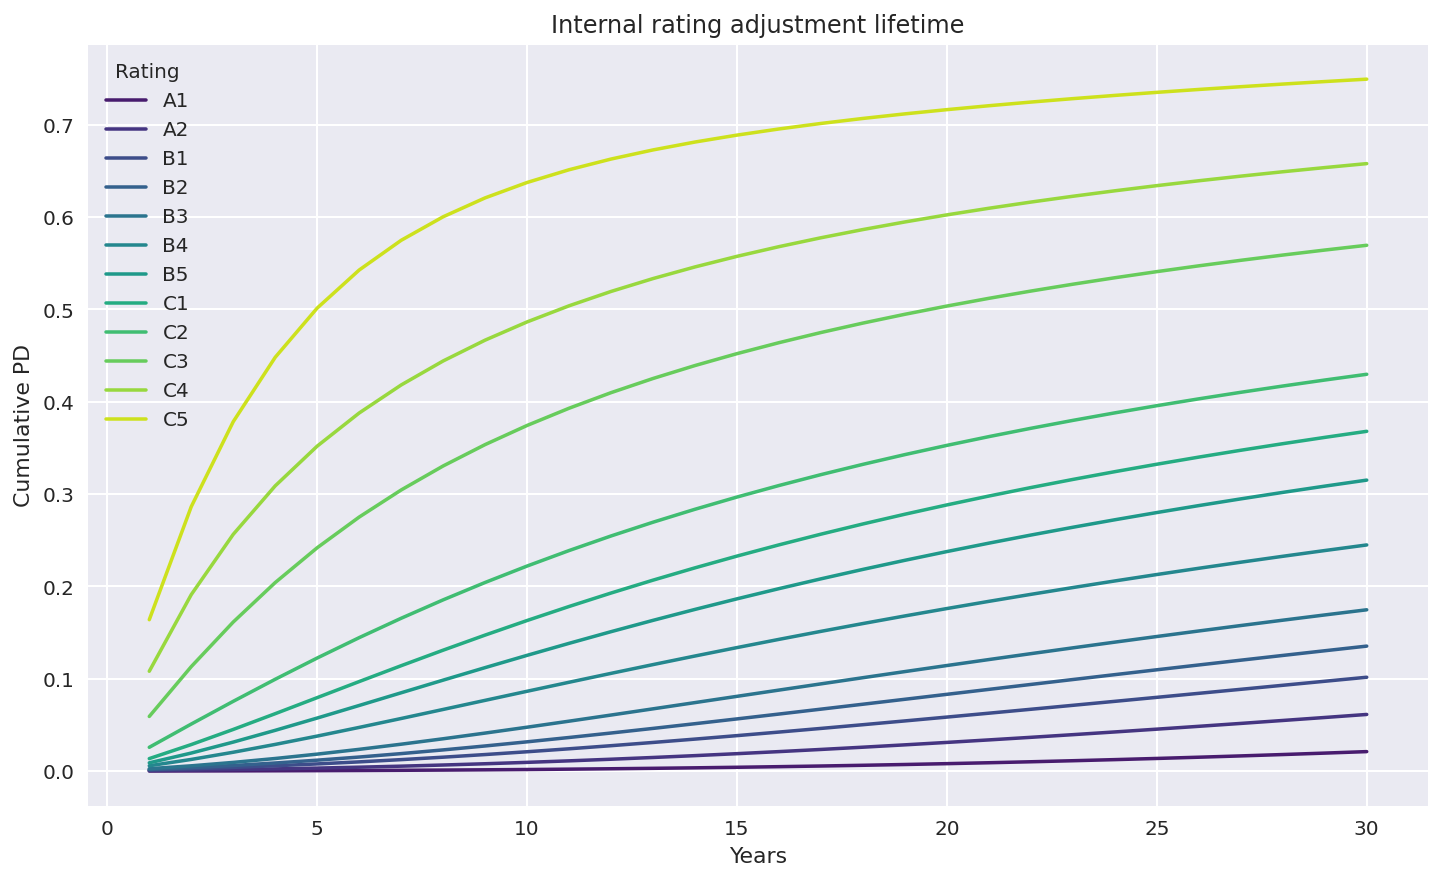

In [28]:
# Plot
plotLifetime(longTable(lifetimeInternal.set_index('internalRating').T, 'Rating', 'cumPD'),
             "Internal rating adjustment lifetime", 'Rating', 'cumPD')

In [29]:
# Proof
# Mapped result * scalar --> year 1 PD
mappedResult['fittedDefault'] * scalar

0    0.0000
1    0.0004
2    0.0011
3    0.0017
4    0.0025
5    0.0057
6    0.0089
7    0.0135
8    0.0257
9    0.0591
10   0.1081
11   0.1639
Name: fittedDefault, dtype: float64